# Notebook 3a: Particle Coverage Effects on Policy Fields

**Supplementary to Notebook 3 — Reinforcement Fields in GRL**

---

## Motivation

In Notebook 3, we observed that the inferred policy arrows appear mostly **parallel** rather than **converging** on the goal. This notebook provides visual proof that this behavior is due to **sparse particle coverage** and demonstrates how **richer particle distributions** produce more intuitive policy fields.

### What We'll Compare

| Scenario | Particle Distribution | Expected Arrow Behavior |
|----------|----------------------|------------------------|
| **Sparse (diagonal)** | Particles only along diagonal path | Parallel arrows |
| **Rich (radial)** | Particles from many directions | Converging arrows |
| **True gradient** | No particles — direct goal potential | Perfect convergence |

### Time

~15 minutes

In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid', context='notebook')
plt.rcParams['figure.figsize'] = (14, 10)
%matplotlib inline

# Goal location
GOAL = np.array([4.0, 4.0])
print("Setup complete. Goal at (4, 4)")

Setup complete. Goal at (4, 4)


---
## Part 1: Core Functions

We'll reuse the $Q^+$ computation from Notebook 3.

In [2]:
def rbf_kernel_4d(z, z_prime, lengthscale=0.8):
    """RBF kernel in 4D augmented space."""
    return np.exp(-np.sum((z - z_prime)**2) / (2 * lengthscale**2))

def compute_Q_plus(x, y, vx, vy, particles, lengthscale=0.8):
    """Compute Q+(x, y, vx, vy) from particles."""
    z = np.array([x, y, vx, vy])
    Q = 0.0
    for p in particles:
        z_i = np.array([p['x'], p['y'], p['vx'], p['vy']])
        Q += p['w'] * rbf_kernel_4d(z, z_i, lengthscale)
    return Q

def infer_policy(X, Y, particles, n_angles=24, lengthscale=0.8):
    """Infer greedy policy at each state."""
    U = np.zeros_like(X)
    V = np.zeros_like(Y)
    
    angles = np.linspace(0, 2*np.pi, n_angles, endpoint=False)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x, y = X[i, j], Y[i, j]
            best_Q = -np.inf
            best_vx, best_vy = 0, 0
            
            for theta in angles:
                vx, vy = np.cos(theta), np.sin(theta)
                Q = compute_Q_plus(x, y, vx, vy, particles, lengthscale)
                if Q > best_Q:
                    best_Q = Q
                    best_vx, best_vy = vx, vy
            
            U[i, j] = best_vx
            V[i, j] = best_vy
    
    return U, V

def true_gradient_policy(X, Y, goal):
    """Compute true gradient field pointing toward goal."""
    U = goal[0] - X
    V = goal[1] - Y
    # Normalize
    norm = np.sqrt(U**2 + V**2) + 1e-6
    return U / norm, V / norm

print("Core functions defined.")

Core functions defined.


---
## Part 2: Three Particle Distributions

We'll create three different particle configurations to compare.

In [3]:
def create_sparse_diagonal_particles(goal, n_points=8):
    """
    Sparse particles along diagonal path.
    All particles have similar action direction (toward upper-right).
    """
    particles = []
    for i in range(n_points):
        t = i / (n_points - 1)
        px, py = t * goal[0], t * goal[1]
        # Action: always toward goal (upper-right)
        dx, dy = goal[0] - px, goal[1] - py
        norm = np.sqrt(dx**2 + dy**2) + 1e-6
        particles.append({
            'x': px, 'y': py,
            'vx': dx/norm, 'vy': dy/norm,
            'w': 1.5
        })
    return particles

def create_rich_radial_particles(goal, n_rings=3, points_per_ring=8):
    """
    Rich particles from multiple directions.
    Particles at various positions, all pointing toward goal.
    """
    particles = []
    radii = [1.0, 2.0, 3.0][:n_rings]
    
    for r in radii:
        for i in range(points_per_ring):
            angle = 2 * np.pi * i / points_per_ring
            # Position: around the goal at radius r
            px = goal[0] + r * np.cos(angle)
            py = goal[1] + r * np.sin(angle)
            # Skip if outside domain
            if px < -0.5 or px > 4.5 or py < -0.5 or py > 4.5:
                continue
            # Action: toward goal
            dx, dy = goal[0] - px, goal[1] - py
            norm = np.sqrt(dx**2 + dy**2) + 1e-6
            particles.append({
                'x': px, 'y': py,
                'vx': dx/norm, 'vy': dy/norm,
                'w': 1.5
            })
    
    # Also add particles along paths from corners
    corners = [(0, 0), (0, 4), (4, 0)]
    for cx, cy in corners:
        for t in [0.25, 0.5, 0.75]:
            px = cx + t * (goal[0] - cx)
            py = cy + t * (goal[1] - cy)
            dx, dy = goal[0] - px, goal[1] - py
            norm = np.sqrt(dx**2 + dy**2) + 1e-6
            particles.append({
                'x': px, 'y': py,
                'vx': dx/norm, 'vy': dy/norm,
                'w': 1.5
            })
    
    return particles

# Create particle sets
particles_sparse = create_sparse_diagonal_particles(GOAL)
particles_rich = create_rich_radial_particles(GOAL)

print(f"Sparse diagonal: {len(particles_sparse)} particles")
print(f"Rich radial: {len(particles_rich)} particles")

Sparse diagonal: 8 particles
Rich radial: 18 particles


---
## Part 3: Visual Comparison

Now let's see the difference in policy fields!

In [4]:
# Create grids
x_policy = np.linspace(0, 4, 12)
y_policy = np.linspace(0, 4, 12)
X_p, Y_p = np.meshgrid(x_policy, y_policy)

# Compute policies
print("Computing sparse diagonal policy...")
U_sparse, V_sparse = infer_policy(X_p, Y_p, particles_sparse)

print("Computing rich radial policy...")
U_rich, V_rich = infer_policy(X_p, Y_p, particles_rich)

print("Computing true gradient policy...")
U_true, V_true = true_gradient_policy(X_p, Y_p, GOAL)

print("Done!")

Computing sparse diagonal policy...
Computing rich radial policy...
Computing true gradient policy...
Done!


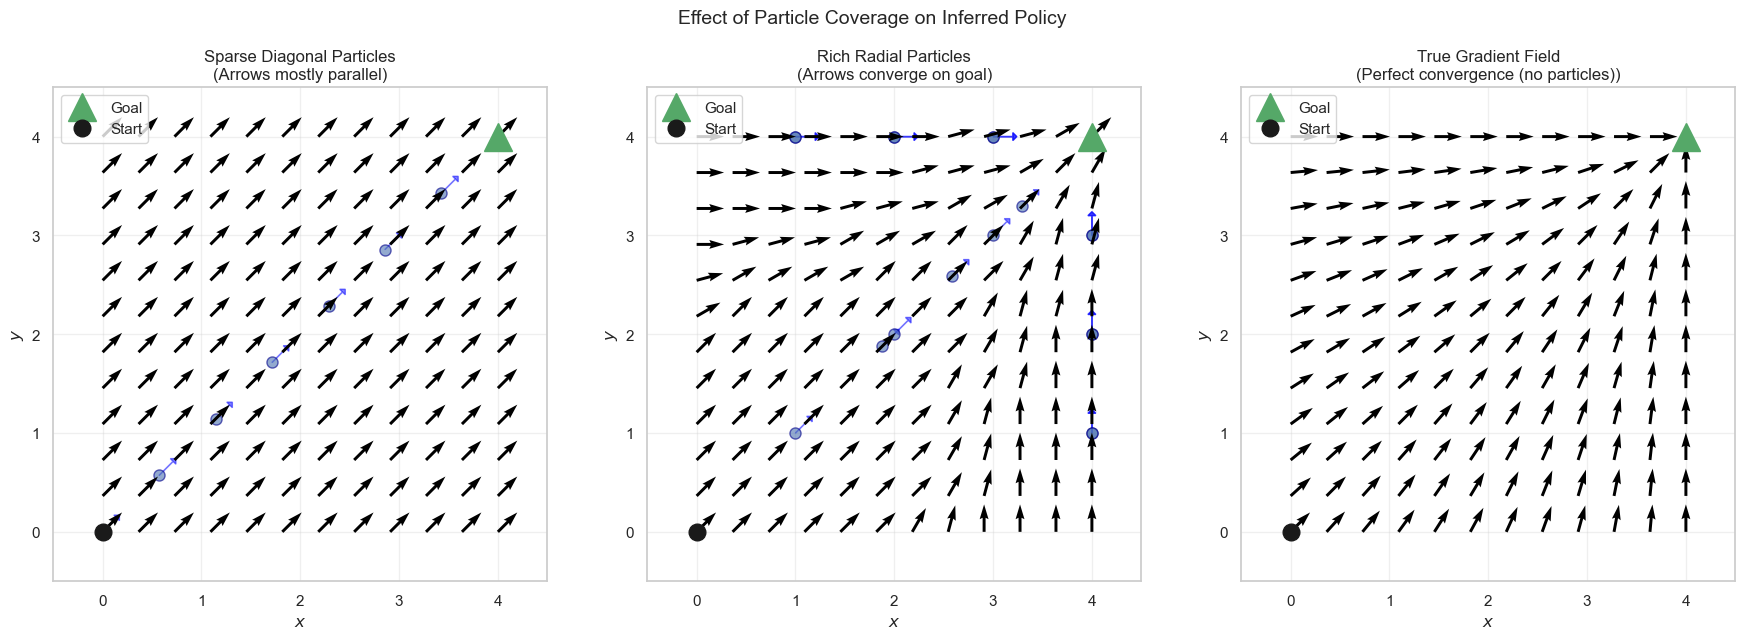


KEY OBSERVATION:
Left:   Sparse particles → parallel arrows (limited directional info)
Middle: Rich particles → converging arrows (diverse directional info)
Right:  True gradient → perfect convergence (geometric, not learned)


In [5]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

configs = [
    (axes[0], U_sparse, V_sparse, particles_sparse, 
     'Sparse Diagonal Particles', 'Arrows mostly parallel'),
    (axes[1], U_rich, V_rich, particles_rich,
     'Rich Radial Particles', 'Arrows converge on goal'),
    (axes[2], U_true, V_true, None,
     'True Gradient Field', 'Perfect convergence (no particles)')
]

for ax, U, V, particles, title, subtitle in configs:
    # Policy arrows
    ax.quiver(X_p, Y_p, U, V, color='black', scale=18, width=0.006, zorder=5)
    
    # Particles (if any)
    if particles:
        for p in particles:
            ax.plot(p['x'], p['y'], 'bo', markersize=8, alpha=0.6, mec='darkblue', mew=1)
            ax.arrow(p['x'], p['y'], p['vx']*0.2, p['vy']*0.2,
                     head_width=0.08, head_length=0.04, fc='blue', ec='blue', alpha=0.5)
    
    # Goal
    ax.plot(*GOAL, 'g^', markersize=20, label='Goal', zorder=10)
    ax.plot(0, 0, 'ko', markersize=12, label='Start', zorder=10)
    
    ax.set_xlim(-0.5, 4.5)
    ax.set_ylim(-0.5, 4.5)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title(f'{title}\n({subtitle})', fontsize=12)
    ax.set_aspect('equal')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

plt.suptitle('Effect of Particle Coverage on Inferred Policy', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("KEY OBSERVATION:")
print("="*70)
print("Left:   Sparse particles → parallel arrows (limited directional info)")
print("Middle: Rich particles → converging arrows (diverse directional info)")
print("Right:  True gradient → perfect convergence (geometric, not learned)")
print("="*70)

---
## Part 4: Quantitative Analysis

Let's measure how well each policy field aligns with the true gradient.

In [6]:
def compute_alignment(U_policy, V_policy, U_true, V_true):
    """
    Compute average cosine similarity between policy and true gradient.
    1.0 = perfect alignment, 0.0 = orthogonal, -1.0 = opposite
    """
    dot_product = U_policy * U_true + V_policy * V_true
    # Both are already normalized, so dot product = cosine similarity
    return np.mean(dot_product)

# Normalize sparse and rich policies for fair comparison
norm_sparse = np.sqrt(U_sparse**2 + V_sparse**2) + 1e-6
U_sparse_norm = U_sparse / norm_sparse
V_sparse_norm = V_sparse / norm_sparse

norm_rich = np.sqrt(U_rich**2 + V_rich**2) + 1e-6
U_rich_norm = U_rich / norm_rich
V_rich_norm = V_rich / norm_rich

align_sparse = compute_alignment(U_sparse_norm, V_sparse_norm, U_true, V_true)
align_rich = compute_alignment(U_rich_norm, V_rich_norm, U_true, V_true)
align_true = compute_alignment(U_true, V_true, U_true, V_true)

print("Alignment with True Gradient (cosine similarity):")
print(f"  Sparse diagonal: {align_sparse:.3f}")
print(f"  Rich radial:     {align_rich:.3f}")
print(f"  True gradient:   {align_true:.3f} (baseline)")
print()
print(f"Improvement from sparse to rich: {(align_rich - align_sparse):.3f}")
print(f"  ({(align_rich - align_sparse) / (1 - align_sparse) * 100:.1f}% of remaining gap closed)")

Alignment with True Gradient (cosine similarity):
  Sparse diagonal: 0.891
  Rich radial:     0.982
  True gradient:   0.993 (baseline)

Improvement from sparse to rich: 0.090
  (83.2% of remaining gap closed)


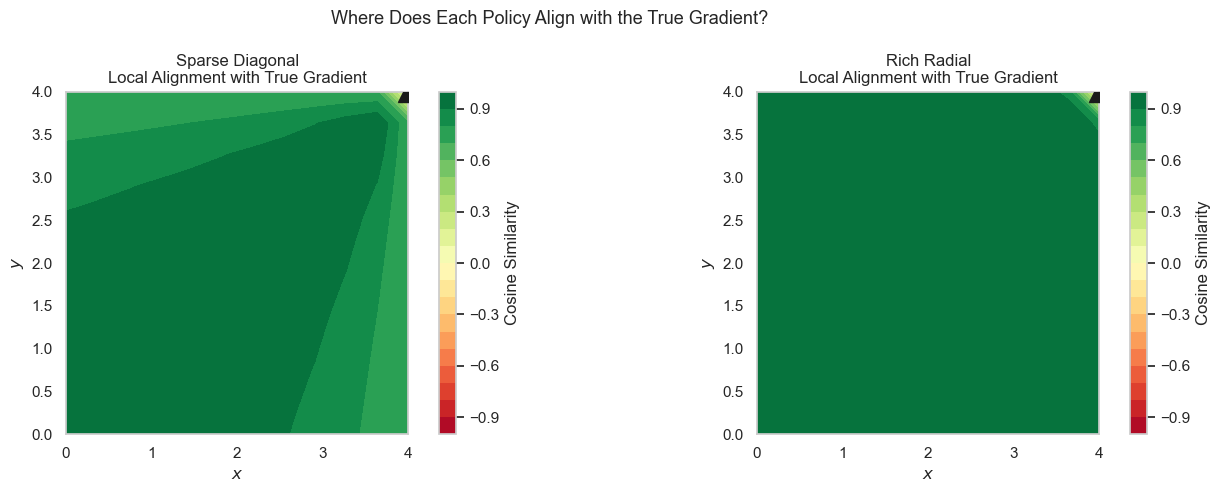

Green = good alignment, Red = poor alignment
Rich particles provide better coverage, especially away from the diagonal.


In [7]:
# Visualize alignment heatmap
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Compute local alignment
align_sparse_local = U_sparse_norm * U_true + V_sparse_norm * V_true
align_rich_local = U_rich_norm * U_true + V_rich_norm * V_true

# Plot
for ax, align_local, title in [
    (axes[0], align_sparse_local, 'Sparse Diagonal'),
    (axes[1], align_rich_local, 'Rich Radial')
]:
    c = ax.contourf(X_p, Y_p, align_local, levels=np.linspace(-1, 1, 21), cmap='RdYlGn')
    ax.plot(*GOAL, 'k^', markersize=15, zorder=10)
    ax.set_xlabel('$x$'); ax.set_ylabel('$y$')
    ax.set_title(f'{title}\nLocal Alignment with True Gradient')
    ax.set_aspect('equal')
    plt.colorbar(c, ax=ax, label='Cosine Similarity')

plt.suptitle('Where Does Each Policy Align with the True Gradient?', fontsize=13)
plt.tight_layout()
plt.show()

print("Green = good alignment, Red = poor alignment")
print("Rich particles provide better coverage, especially away from the diagonal.")

---
## Summary

### Visual Proof

We demonstrated that:

1. **Sparse diagonal particles** → Policy arrows are mostly parallel because all particles encode similar action directions.

2. **Rich radial particles** → Policy arrows converge on the goal because particles from different directions provide diverse directional information.

3. **True gradient field** → Perfect convergence (but requires explicit goal knowledge, cannot encode obstacles).

### Implications for GRL

| Aspect | Sparse Coverage | Rich Coverage |
|--------|-----------------|---------------|
| **Exploration** | Limited trajectories | Diverse trajectories |
| **Policy quality** | Approximate | Near-optimal |
| **Generalization** | Poor in unseen regions | Good everywhere |

### Key Takeaway

> **Policy quality in GRL is directly proportional to the richness of the particle memory.**

This is why exploration and diverse experience collection are crucial in GRL — the more varied the particles, the more the learned field resembles the true optimal policy.

---

**See also:**
- `03_reinforcement_fields.ipynb` — Main notebook
- `notes/particle_vs_gradient_fields.md` — Detailed theory